# PW5 — Wellenoptik 

---

## Allgemeine Grundlagen

### Lehr- und Lernziele
- Arbeiten mit den Welleneigenschaften des Lichts  
- Interferenz- und Beugungsprozesse verstehen  
- Interferenzbedingungen verstehen  
- Übergang von Einzelspalt zu Doppelspalt und Beugungsgitter nachvollziehen  

**Begriffe:**  
Wellenoptik, Interferenz, Kohärenz, Huygens-Fresnel’sches Prinzip, Fraunhofer’sche und Fresnel’sche Beugungserscheinungen, Laser

---

### Licht als Welle – Interferenz

Licht kann als elektromagnetische Welle beschrieben werden. Darauf weisen Interferenz- und Beugungsphänomene hin.  
Die Vektoren der elektrischen und magnetischen Feldstärke stehen senkrecht aufeinander und auf die Ausbreitungsrichtung.

$$
E(x, t) = E_0 e^{i\omega (t - x/c)}
$$

Nur der **Realteil** dieser Gleichung ist physikalisch bedeutungsvoll.  
Dabei gilt:
- $ E_0 = |E_0| $: Amplitude  
- $ \omega = 2\pi\nu $: Kreisfrequenz  
- $ c $: Ausbreitungsgeschwindigkeit  

Zusammenhang zwischen Frequenz und Wellenlänge:

$$
c = \lambda \nu
$$

Die beobachtbare **Intensität** ist proportional zum zeitlichen Mittelwert des Betragsquadrats der Feldstärke:

$$
I \propto \langle |E(x, t)|^2 \rangle = \langle E(x,t)E^*(x,t)\rangle
$$

Überlagern sich zwei Wellen, ergibt sich:

$$
E_1(x,t) = E_{01} e^{i\omega(t-x/c)} \quad \text{und} \quad E_2(x,t) = E_{02} e^{i(\omega(t-x/c)+\delta)}
$$

mit Phasenverschiebung  
$$
\delta = \frac{2\pi \Delta x}{\lambda}
$$

Gesamtfeld:

$$
E(x,t) = (E_{01} + E_{02} e^{i\delta}) e^{i\omega(t-x/c)}
$$

Intensität:

$$
I \propto (E_{01} + E_{02} e^{i\delta})(E_{01} + E_{02} e^{-i\delta}) = E_{01}^2 + E_{02}^2 + 2E_{01}E_{02}\cos\delta
$$

Mit $ I_1 = E_{01}^2 $ und $ I_2 = E_{02}^2 $:

$$
I = I_1 + I_2 + 2\sqrt{I_1 I_2}\cos\delta
$$

**Konstruktive Interferenz:** $ \delta = 2k\pi \Rightarrow \Delta x = k\lambda $  
**Destruktive Interferenz:** $ \delta = (2k + 1)\pi \Rightarrow \Delta x = k\lambda + \frac{\lambda}{2} $

---

### Kohärenz

Interferenz ist nur möglich, wenn die überlagerten Wellen kohärent sind.  
Licht besteht aus **zeitlich und räumlich begrenzten Wellengruppen**, deren Länge $ l $ die **Kohärenzlänge** und deren Dauer $ \tau $ die **Kohärenzdauer** genannt wird.

Bedingungen für beobachtbare Interferenz:

- Die **Wegdifferenz** der interferierenden Wellen muss kleiner als die Kohärenzlänge sein.  
- Die **Phasendifferenz** darf sich während der Beobachtungszeit nicht wesentlich ändern.  

Für ausgedehnte Lichtquellen gilt zusätzlich:

$$
\sin u \leq \frac{\lambda}{2y}
$$

wobei $ u $ der Öffnungswinkel und $ y $ die Ausdehnung der Quelle ist.

---

### Laser

In normalen Lichtquellen dominiert **spontane Emission** – jedes Atom sendet unabhängig Licht aus.  
Beim **Laser** (Light Amplification by Stimulated Emission of Radiation) überwiegt die **induzierte Emission**.

Ein **aktives Medium** (z. B. He-Ne-Gas, Rubin, Halbleiter) wird durch äußere Anregung in einen Zustand der **Besetzungsinversion** gebracht.  
Zwischen zwei Spiegeln entsteht ein optischer Resonator, der kohärentes, monochromatisches Licht mit großer Kohärenzlänge liefert.

Eigenschaften von Laserlicht:
- hohe räumliche und zeitliche Kohärenz  
- hohe spektrale Energiedichte  
- große Amplitudenstabilität  
- geringe Divergenz  

---

### Fraunhofer- und Fresnelbeugung

Trifft Licht auf ein Hindernis (z. B. Spalt, Draht), wird es **gebeugt**.  
Nach dem **Huygensschen Prinzip** wirkt jeder Punkt einer Wellenfront als Ausgangspunkt einer Elementarwelle.

Für eine Öffnung der Breite $ a $ gilt:

$$
R \gg \frac{a^2}{\lambda}
$$

Dann spricht man von **Fraunhofer- (Fernfeld-)Beugung**.  
Wird diese Bedingung nicht erfüllt, beobachtet man **Fresnel- (Nahfeld-)Beugung**.

- **Fraunhoferbeugung:** klare, stationäre Interferenzstreifen, die sich mit zunehmendem Abstand besser trennen.  
- **Fresnelbeugung:** komplexe Muster, die sich mit dem Abstand verändern (z. B. Talbot-Abbildungen).

---


## Auswertung – Beugung am Einzelspalt
Für die Beugungsminima eines Einzelspalts gilt die Beziehung:

$$
a \sin \alpha_n = n \lambda
$$

mit  
- $a$: Spaltbreite  
- $\alpha_n$: Ablenkwinkel des n-ten Minimums  
- $\lambda$: Wellenlänge des verwendeten Lichts  
- $n = 1, 2, 3, ...$: Ordnungszahl des Minimums  

Da die Winkel klein sind ($<5°$), gilt näherungsweise:

$$
\sin \alpha_n \approx \tan \alpha_n = \frac{y_n}{L}
$$

Hierbei ist  
- $y_n$: Abstand des n-ten Minimums vom Zentralmaximum auf dem Schirm  
- $L$: Abstand zwischen Spalt und Schirm  

Daraus folgt:

$$
a = \frac{n \lambda L}{y_n}
$$

Zur genaueren Bestimmung von $a$ wird ein Diagramm erstellt, in dem  
auf der Ordinate $n\lambda$ und auf der Abszisse $\alpha_n$ (in Radiant) aufgetragen wird.  
Die Punkte sollten annähernd auf einer Geraden liegen, deren **Steigung die Spaltbreite $a$** darstellt.  
Durch lineare Regression erhält man den exakten Wert von $a$ einschließlich Unsicherheit.

---

=== PARAMETER UND DATEN ===
λ = 650.0 nm
L = 1500.0 mm

Verwendete Messpunkte: 6
     y_mm  alpha_grad
1   48.25    1.842379
2   95.50    3.642914
3  144.25    5.493052
4  191.50    7.275405
5  240.25    9.099588
6  289.25   10.914567

=== SCHÄTZUNG DER SPALTBREITE a (n·λ = a·α) ===
a = 20.453 ± 0.021 µm
R² = 0.99999


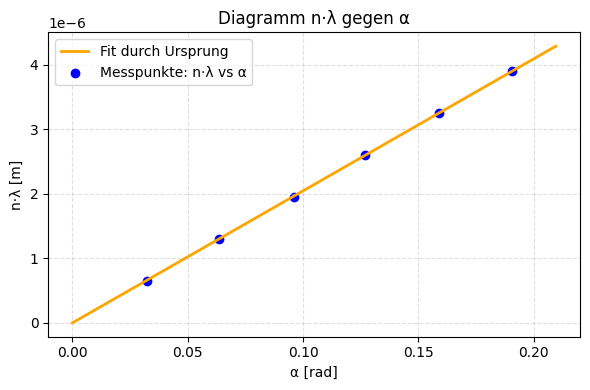

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# --------------------------- EINGABEDATEN -------------------------------------
# Wellenlänge und Geometrie (anpassen!)
lambda_nm = 650.0        # Wellenlänge des Lasers in nm (z. B. 650 nm)
L_mm = 1500.0            # Abstand Spalt–Schirm in mm (z. B. 1,5 m = 1500 mm)

# Symmetrische Paare links/rechts gemessen (+/-)
# Spalten: n, y_minus_mm (links), y_plus_mm (rechts)
data_paare = pd.DataFrame({
    "n": [1, 2, 3, 4, 5, 6],
    "y_minus_mm": [-48.5, -96.0, -144.5, -192.0, -240.0, -289.5],  
    "y_plus_mm":  [ 48.0,  95.0,  144.0,  191.0,  240.5,  289.0]
})

# ---------------------- DATENVORBEREITUNG -------------------------------------
lambda_m = lambda_nm * 1e-9
L_m = L_mm * 1e-3

df = data_paare.copy()
# Halber Abstand vom Zentrum: Mittelwert der Abweichungen links/rechts
df["y_halb_mm"] = (df["y_plus_mm"] - df["y_minus_mm"]) / 2.0
y_mm = df["y_halb_mm"].to_numpy()
n_ord = df["n"].to_numpy().astype(float)


y_m = y_mm * 1e-3

# Winkelberechnung: α = arctan(y / L)
# Für kleine Winkel gilt sin(α) ≈ α ≈ y/L.
alpha_rad = np.arctan2(y_m, L_m)

# Abhängige Variable: n·λ (nach der Beziehung n·λ = a·α)
y_dep = n_ord * lambda_m
x_alpha = alpha_rad

def fit_durch_nullpunkt(x, y):
    """
    Berechnet die Steigung k in Modell y = k·x (durch Ursprung) mit Unsicherheit und R².
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    # k = (x·y)/(x·x)
    k = np.dot(x, y) / np.dot(x, x)

    # Residuen und Varianz
    y_hat = k * x
    resid = y - y_hat
    dof = max(1, len(x) - 1)
    sigma2 = np.dot(resid, resid) / dof

    var_k = sigma2 / np.dot(x, x)
    se_k = np.sqrt(var_k)

    sse = np.dot(resid, resid)
    sst0 = np.dot(y, y)
    r2_0 = 1.0 - sse / sst0 if sst0 > 0 else np.nan
    return k, se_k, r2_0, y_hat, resid

# Fit nach n·λ = a·α
a_alpha, a_alpha_se, r2_alpha, yhat_alpha, resid_alpha = fit_durch_nullpunkt(x_alpha, y_dep)

# --------------------------- AUSGABE ------------------------------------------
print("=== PARAMETER UND DATEN ===")
print(f"λ = {lambda_nm:.1f} nm")
print(f"L = {L_mm:.1f} mm")
print("\nVerwendete Messpunkte:", len(n_ord))
print(pd.DataFrame({"y_mm": y_mm, "alpha_grad": np.degrees(alpha_rad)}, index=np.arange(1, len(n_ord) + 1)))

print("\n=== SCHÄTZUNG DER SPALTBREITE a (n·λ = a·α) ===")
print(f"a = {a_alpha*1e6:.3f} ± {a_alpha_se*1e6:.3f} µm")
print(f"R² = {r2_alpha:.5f}")

# ------------------------------ VISUALISIERUNG -------------------------------
# 1) Diagramm: n·λ gegen α (in Rad)
fig1 = plt.figure(figsize=(6, 4))
x_line = np.linspace(0, x_alpha.max()*1.1, 100)
plt.plot(x_line, a_alpha * x_line, label="Fit durch Ursprung", linewidth=2, color="orange")
plt.scatter(x_alpha, y_dep, label="Messpunkte: n·λ vs α", color="blue")
plt.xlabel("α [rad]")
plt.ylabel("n·λ [m]")
plt.title("Diagramm n·λ gegen α")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## Auswertung – Beugung und Interferenz am Doppelspalt

Die Intensitätsverteilung lautet:

$$
I(\alpha) = 4 I_0 \cos^2\!\left(\frac{\pi b \sin\alpha}{\lambda}\right)
\left(\frac{\sin(\pi a \sin\alpha / \lambda)}{\pi a \sin\alpha / \lambda}\right)^2
$$

- $ a$: Spaltbreite (Breite jedes einzelnen Spalts)  
- $ b$: Spaltabstand (Abstand der Spaltmitten)  
- $ \lambda$: Wellenlänge des verwendeten Lichts  
- $ \alpha$: Beugungswinkel

Die **cos²-Funktion** beschreibt das Interferenzmuster (enge Maxima und Minima),  
die **sin²/β²-Funktion** die Beugungshüllkurve.

### Bedingungen für Maxima und Minima

- **Interferenzmaxima** (helle Streifen):
  $$
  b \sin\alpha_{\text{max},k} = k\lambda \quad (k = 0,1,2,\dots)
  $$

- **Interferenzminima** (dunkle Streifen):
  $$
  b \sin\alpha_{\text{min},k} = \left(k+\frac{1}{2}\right)\lambda
  $$

- **Beugungsminima** (Hüllkurven-Minima):
  $$
  a \sin\alpha_{\text{min},n} = n\lambda
  $$

Das gesamte Muster kann daher als Produkt aus der **Einzelspalt-Beugung** und der **Doppelspalt-Interferenz** verstanden werden.

### Bestimmung der Parameter
1. **Bestimmung der Hüllkurve (a):**  
   Aus den Minima der äußeren Beugungshüllkurve (wie beim Einzelspalt).

2. **Bestimmung der Interferenzstreifen (b):**  
   Messung der Winkel der feinen Minima (dunklen Linien) zwischen den Maxima,  
   anschließend lineare Auswertung mit
   $$
   \sin\alpha_k = m(2k+1), \quad m = \frac{\lambda}{2b}.
   $$
   Daraus folgt:
   $$
   b = \frac{\lambda}{2m}.
   $$



=== PARAMETER UND DATEN ===
λ = 650.0 nm
L = 1500.0 mm

Verwendete Messpunkte: 6
     y_mm  alpha_grad
1   48.25    1.842379
2   95.50    3.642914
3  144.25    5.493052
4  191.50    7.275405
5  240.25    9.099588
6  289.25   10.914567

=== SCHÄTZUNG DER SPALTBREITE a (n·λ = a·α) ===
a = 20.453 ± 0.021 µm
R² = 0.99999


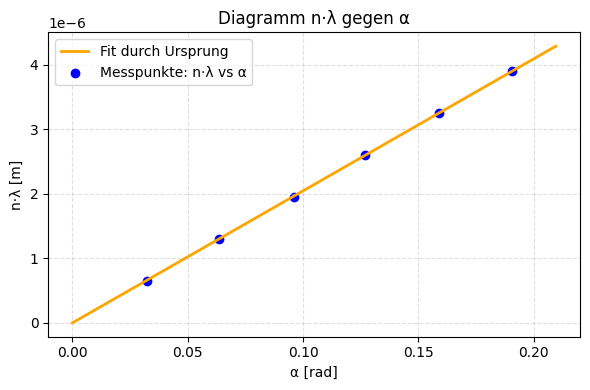


Tabelle (Doppelspalt-Minima)
   y_minus_mm  y_plus_mm  y_halb_mm
1       -22.5       22.3      22.40
2       -45.0       44.8      44.90
3       -67.2       66.9      67.05
4       -90.1       90.0      90.05

Ergebnis Spaltabstand b:
b = 36.524 ± 1.872 µm   (R²(0) = 0.99218)


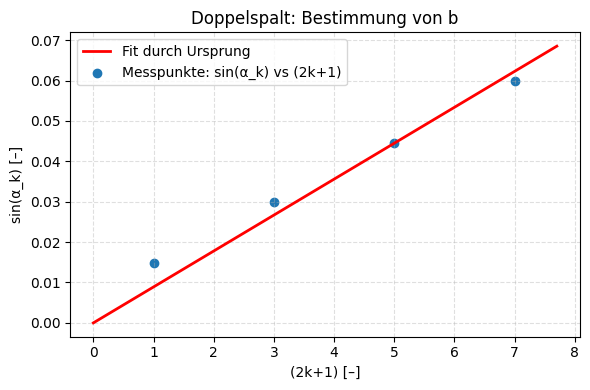

In [6]:
# =========================== EINGABEDATEN =====================================
# Wellenlänge und Geometrie
lambda_nm = 650.0        # Laserwellenlänge in nm
L_mm = 1500.0            # Abstand Spalt–Schirm in mm (z. B. 1500 mm = 1.5 m)

# --- Teil A: Hüllkurve (Einzelspalt-Minima) zur Bestimmung von a --------------
# Symmetrische Paare: Spalten n, y_minus_mm (links, negativ), y_plus_mm (rechts, positiv)
data_huelle = pd.DataFrame({
     "n": [1, 2, 3, 4, 5, 6],
     "y_minus_mm": [-48.5, -96.0, -144.5, -192.0, -240.0, -289.5],
     "y_plus_mm":  [ 48.0,  95.0,  144.0,  191.0,  240.5,  289.0],
})

# --- Teil B: Doppelspalt-Minima zur Bestimmung von b --------------------------
# Symmetrische Paare: k (0,1,2,...), y_minus_mm, y_plus_mm
# Das sind die "feinen" Minima innerhalb der Hüllkurven-Maxima.
data_doppel = pd.DataFrame({
     "k": [0,1,2,3],
     "y_minus_mm": [-22.5, -45.0, -67.2, -90.1],
     "y_plus_mm":  [ 22.3,  44.8,  66.9,  90.0],
})

# =========================== HILFSFUNKTIONEN ==================================
def fit_durch_nullpunkt(x, y):
    """
    Schätzt Steigung k im Modell y = k·x (Fit durch Ursprung) und liefert
    (k, se_k, R2_0, y_hat, resid).
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if len(x) < 2:
        raise ValueError("Mindestens zwei Messpunkte erforderlich.")
    xx = np.dot(x, x)
    k = np.dot(x, y) / xx
    y_hat = k * x
    resid = y - y_hat
    dof = len(x) - 1
    sigma2 = np.dot(resid, resid) / dof
    se_k = np.sqrt(sigma2 / xx)
    sse = np.dot(resid, resid)
    sst0 = np.dot(y, y)
    R2_0 = 1.0 - sse / sst0 if sst0 > 0 else np.nan
    return k, se_k, R2_0, y_hat, resid

def mm_to_m(x_mm): return np.asarray(x_mm, dtype=float) * 1e-3

# =============================== AUSWERTUNG ===================================
lambda_m = float(lambda_nm) * 1e-9
L_m = float(L_mm) * 1e-3

# --------------------------- TEIL A: a aus Hüllkurve --------------------------

df = data_huelle.copy()
# Halber Abstand vom Zentrum: Mittelwert der Abweichungen links/rechts
df["y_halb_mm"] = (df["y_plus_mm"] - df["y_minus_mm"]) / 2.0
y_mm = df["y_halb_mm"].to_numpy()
n_ord = df["n"].to_numpy().astype(float)


y_m = y_mm * 1e-3

# Winkelberechnung: α = arctan(y / L)
# Für kleine Winkel gilt sin(α) ≈ α ≈ y/L.
alpha_rad = np.arctan2(y_m, L_m)

# Abhängige Variable: n·λ (nach der Beziehung n·λ = a·α)
y_dep = n_ord * lambda_m
x_alpha = alpha_rad

def fit_durch_nullpunkt(x, y):
    """
    Berechnet die Steigung k in Modell y = k·x (durch Ursprung) mit Unsicherheit und R².
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    # k = (x·y)/(x·x)
    k = np.dot(x, y) / np.dot(x, x)

    # Residuen und Varianz
    y_hat = k * x
    resid = y - y_hat
    dof = max(1, len(x) - 1)
    sigma2 = np.dot(resid, resid) / dof

    var_k = sigma2 / np.dot(x, x)
    se_k = np.sqrt(var_k)

    sse = np.dot(resid, resid)
    sst0 = np.dot(y, y)
    r2_0 = 1.0 - sse / sst0 if sst0 > 0 else np.nan
    return k, se_k, r2_0, y_hat, resid

# Fit nach n·λ = a·α
a_alpha, a_alpha_se, r2_alpha, yhat_alpha, resid_alpha = fit_durch_nullpunkt(x_alpha, y_dep)

# --------------------------- AUSGABE ------------------------------------------
print("=== PARAMETER UND DATEN ===")
print(f"λ = {lambda_nm:.1f} nm")
print(f"L = {L_mm:.1f} mm")
print("\nVerwendete Messpunkte:", len(n_ord))
print(pd.DataFrame({"y_mm": y_mm, "alpha_grad": np.degrees(alpha_rad)}, index=np.arange(1, len(n_ord) + 1)))

print("\n=== SCHÄTZUNG DER SPALTBREITE a (n·λ = a·α) ===")
print(f"a = {a_alpha*1e6:.3f} ± {a_alpha_se*1e6:.3f} µm")
print(f"R² = {r2_alpha:.5f}")

# ------------------------------ VISUALISIERUNG -------------------------------
# 1) Diagramm: n·λ gegen α (in Rad)
fig1 = plt.figure(figsize=(6, 4))
x_line = np.linspace(0, x_alpha.max()*1.1, 100)
plt.plot(x_line, a_alpha * x_line, label="Fit durch Ursprung", linewidth=2, color="orange")
plt.scatter(x_alpha, y_dep, label="Messpunkte: n·λ vs α", color="blue")
plt.xlabel("α [rad]")
plt.ylabel("n·λ [m]")
plt.title("Diagramm n·λ gegen α")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# --------------------------- TEIL B: b aus Minima -----------------------------

dfB = data_doppel.copy()
dfB.index = np.arange(1, len(dfB)+1)  # 1-basig
dfB["y_halb_mm"] = (dfB["y_plus_mm"] - dfB["y_minus_mm"]) / 2.0
y_m_d = mm_to_m(dfB["y_halb_mm"].to_numpy())
alpha_k = np.arctan2(y_m_d, L_m)
s = np.sin(alpha_k)
X = 2.0 * dfB["k"].to_numpy(dtype=float) + 1.0  # (2k+1)

# Fit: s = m*(2k+1), m = λ/(2b)  →  b = λ/(2m)
m_est, m_se, R2_b, s_hat, resid_b = fit_durch_nullpunkt(X, s)
b_est = lambda_m / (2.0 * m_est)
b_se = (lambda_m / 2.0) * (m_se / (m_est**2))

print("\nTabelle (Doppelspalt-Minima)")
print(dfB[["y_minus_mm","y_plus_mm","y_halb_mm"]])

print("\nErgebnis Spaltabstand b:")
print(f"b = {b_est*1e6:.3f} ± {b_se*1e6:.3f} µm   (R²(0) = {R2_b:.5f})")

# Plot: sin(α_k) gegen (2k+1)
fig3 = plt.figure(figsize=(6,4))
x_line = np.linspace(0, X.max()*1.1, 200)
plt.plot(x_line, m_est * x_line, linewidth=2, label="Fit durch Ursprung", color="red")
plt.scatter(X, s, label="Messpunkte: sin(α_k) vs (2k+1)")
plt.xlabel("(2k+1) [–]")
plt.ylabel("sin(α_k) [–]")
plt.title("Doppelspalt: Bestimmung von b")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


## Grundlagen – Wellenlängenmessung mit dem Beugungsgitter

Ein **Beugungsgitter** besteht aus einer großen Anzahl paralleler, äquidistanter Spalte mit dem Abstand $ g $ (Gitterkonstante).  
Wenn kohärentes Licht oder das Licht einer Spektrallampe auf das Gitter fällt, wird es an jedem Spalt gebeugt.  
Die gebeugten Wellen **interferieren miteinander**, wodurch ein charakteristisches Spektrum aus hellen Linien entsteht.

### Prinzip

Jeder Spalt wirkt wie eine Quelle für Elementarwellen.  
Im Fernfeld (Fraunhofer-Bedingung) überlagern sich diese Wellen.  
Je nach Gangunterschied $ \Delta x = g \sin\alpha $ kommt es zu Verstärkung oder Auslöschung.

Damit ergibt sich die **Gittergleichung**:

$$
g \sin\alpha_k = k \lambda \quad (k = 0, 1, 2, \dots)
$$

- $ g $: Abstand zwischen zwei benachbarten Spalten (Gitterkonstante)  
- $ \alpha_k $: Beugungswinkel der $k$-ten Ordnung  
- $ \lambda $: Wellenlänge des Lichts  
- $ k $: Beugungsordnung (0 = Hauptmaximum, 1 = erste Ordnung usw.)

Nur unter den Winkeln, bei denen die Phasenunterschiede Vielfache von $2\pi$ sind,  
treten **helle Interferenzmaxima** auf.

### Intensitätsverteilung

Die allgemeine Intensität hinter einem Gitter mit $N$ Spalten ergibt sich aus:

$$
I(\alpha) = I_0
\left( \frac{\sin(\delta^*/2)}{\delta^*/2} \right)^2
\left( \frac{\sin(N\delta/2)}{\sin(\delta/2)} \right)^2,
$$

wobei
$$
\delta = \frac{2\pi g \sin\alpha}{\lambda}, \quad
\delta^* = \frac{2\pi a \sin\alpha}{\lambda}.
$$

- Der erste Faktor beschreibt die **Einzelspalt-Beugung** (Hüllkurve).  
- Der zweite Faktor beschreibt die **Interferenz von N Spalten** – die Gitterfunktion.

Mit wachsender Spaltzahl $N$ werden die Maxima **sehr scharf** und liegen **weit voneinander getrennt**.  
Dadurch kann man unterschiedliche Wellenlängen desselben Lichts klar voneinander unterscheiden – das ist die Grundlage der **Spektroskopie**.

### Physikalische Bedeutung

Das Beugungsgitter dient als **optischer Analysator** zur Trennung des Lichts nach seiner Wellenlänge.  
Jede Wellenlänge erfüllt ihre eigene Beugungsbedingung $ g \sin\alpha = k\lambda $  
und erscheint daher unter einem bestimmten Winkel $ \alpha $.

Je größer $ g $ (bzw. je feiner das Gitter, desto kleiner $ g $),  
desto stärker werden die Spektrallinien voneinander getrennt.

### Experimentelles Vorgehen

1. Eine Spektrallampe beleuchtet den Spalt eines Kollimators → paralleles Lichtbündel.  
2. Das Licht trifft **senkrecht auf das Transmissionsgitter**.  
3. Hinter dem Gitter erscheint ein **Spektrum** mit Maxima 1., 2., 3. Ordnung auf beiden Seiten.  
4. Mit einem Goniometer oder Fernrohr werden die Winkel $ \alpha_k $ der einzelnen Linien gemessen.  
   Um die Genauigkeit zu erhöhen, wird der Winkel zwischen den symmetrischen Linien links und rechts gemessen und halbiert.

### Auswertung

Aus der Gittergleichung:
$$
\lambda = \frac{g \sin\alpha_k}{k}.
$$

- $g$ ist bekannt (auf dem Gitter angegeben oder vom Betreuer angegeben).  
- $k$ ist die Ordnung der beobachteten Linie.  
- $ \alpha_k $ wird aus den Messungen bestimmt.  

Für jede beobachtete Linie erhält man also den Wert von $ \lambda $.  
Durch Vergleich mit Tabellenwerten kann man identifizieren, **welches Gas** in der Spektrallampe verwendet wurde (z. B. Natrium, Wasserstoff, Quecksilber).



In [11]:

# --------- Eingabe ---------
# Gitterkonstante g in Metern (z.B. 600 Linien/mm -> g = 1/(600e3) m)
g_m = 1.0 / (600e3)

# Messdaten:
# Entweder alpha_links/alpha_rechts (bevorzugt), ODER direkt alpha_deg_eff angeben.
data = pd.DataFrame({
    # Beispielstruktur – ERSETZEN durch Deine Werte:
     "name": ["gelb","gelb","gruen","gruen","blau"],
     "k":    [1,      2,      1,      2,      1],
     "alpha_links":  [-18.90, -39.10, -20.15, -41.95, -14.10],
     "alpha_rechts": [ 18.95,  39.05,  20.20,  42.05,  14.05]
})

# --------- Verarbeitung ---------
df = data.copy()
if {"alpha_links", "alpha_rechts"}.issubset(df.columns):
    # α = (rechts - links)/2  (symmetrische Ablesung, PW5)
    df["alpha_deg_eff"] = (df["alpha_rechts"].astype(float) - df["alpha_links"].astype(float)) / 2.0
elif "alpha_deg_eff" in df.columns:
    df["alpha_deg_eff"] = df["alpha_deg_eff"].astype(float)
else:
    raise ValueError("Bitte entweder (alpha_links & alpha_rechts) ODER alpha_deg_eff angeben.")

if not {"name", "k"}.issubset(df.columns):
    raise ValueError("Spalten 'name' und 'k' sind erforderlich.")

# α [rad] und sin(α)
alpha_rad = np.deg2rad(df["alpha_deg_eff"].to_numpy(dtype=float))
sin_alpha = np.sin(alpha_rad)

# λ = g*sin(α)/k
k = df["k"].to_numpy(dtype=float)
lambda_m = g_m * sin_alpha / k
lambda_nm = lambda_m * 1e9

# --------- Ausgabe: Einzeltabelle ---------
out = pd.DataFrame({
    "name": df["name"].to_numpy(),
    "k": k.astype(int),
    "alpha_deg": df["alpha_deg_eff"].to_numpy(dtype=float),
    "sin_alpha": sin_alpha,
    "lambda_nm": lambda_nm
})
out.index = np.arange(1, len(out)+1)  # 1-basige Nummerierung
print("=== Messungen (Gitter) ===")
print(f"g = {g_m:.6e} m")
print(out)

# --------- Ausgabe: Statistik je Linie ---------
grp = out.groupby("name")["lambda_nm"]
stats = grp.agg(lambda_mean_nm="mean", lambda_std_nm=lambda s: s.std(ddof=1), N="count").reset_index()
stats.index = np.arange(1, len(stats)+1)
print("\n=== Mittelwerte je Linie ===")
print(stats)


=== Messungen (Gitter) ===
g = 1.666667e-06 m
    name  k  alpha_deg  sin_alpha   lambda_nm
1   gelb  1     18.925   0.324330  540.550325
2   gelb  2     39.075   0.630337  525.280944
3  gruen  1     20.175   0.344889  574.814452
4  gruen  2     42.000   0.669131  557.608839
5   blau  1     14.075   0.243192  405.319670

=== Mittelwerte je Linie ===
    name  lambda_mean_nm  lambda_std_nm  N
1   blau      405.319670            NaN  1
2   gelb      532.915635      10.797083  2
3  gruen      566.211645      12.166206  2


![image.png](wellenlaenge.png)


Unser Meinung nach, muss es <> sein